# Global constants

In [23]:
#GRAIN_TYPE = 'Wheat'
#GRAIN_TYPE = 'newWheatData'
#GRAIN_TYPE = 'CornAdded_Type'
GRAIN_TYPE = 'cleaned_data'
# GRAIN_TYPE = 'Oats'

# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
# GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + '_t2_kcv_dnn_mc.h5'

In [24]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.4.1


In [25]:
print(tf.config.list_physical_devices('GPU'))
# print(tf.version.VERSION)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Helper functions

In [26]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(x=predictions, y=trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

In [27]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'SOUTH DAKOTA']
#df = df[(df['Density'] >= 0.72) & (df['Density'] <= 0.88)]

print("From USDA: ", URL)


df.head()

From USDA:  ../Datasets/processed/cleaned_data.csv


,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243,15.855506,-6.341975,62.3,61.7806
1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246,15.855506,-11.142320,71.2,82.0576
2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246,15.855506,-14.537729,80.1,104.1111
3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246,15.855506,10.470049,89.0,128.7950
4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238,15.855506,6.066299,97.9,151.4139


# 2. Overview of data


In [28]:
# Data summary
df.describe()

,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,10.811414,7.088834,16.189541,0.796298,18.410033,-4.604663,-633.488065,2.912112,0.499187,16.189541,-0.377074,77.159677,215.799030
std,3.530055,1.554604,3.794772,0.067384,5.946835,101.951444,219.510760,0.305758,0.186739,0.629743,6.071761,32.552200,124.108325
min,5.000000,4.400000,10.260000,0.625400,8.002300,-179.335000,-1274.435000,2.340000,0.220000,15.352809,-17.418676,22.000000,40.011500
25%,8.000000,6.500000,13.680000,0.745400,13.524700,-88.842000,-793.405750,2.688500,0.337000,15.855506,-5.077754,52.800000,107.817375
50%,11.000000,7.700000,16.225000,0.801300,18.131600,-9.838500,-602.380500,2.861500,0.470500,16.400366,-0.589378,71.200000,195.600450
75%,13.000000,7.700000,18.810000,0.842000,23.098000,80.957250,-456.055750,3.109750,0.639000,16.401988,4.300734,100.100000,310.863000
max,18.000000,8.900000,24.410000,0.927800,29.897000,179.048000,-235.044000,4.038000,0.987000,17.344167,14.827701,160.200000,538.146000


In [29]:
# Dimension of the dataset
df.shape

(806, 14)

In [30]:
# Check info about missing values in dataframe
df.isnull().sum()

Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
Type                      0
Phase/Attn                0
Freq*d(cm)                0
Freq*Attn                 0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [31]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                   # 'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Type',
                    ]]

df_targets = df[['M%', 'Density']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [32]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.15
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalize datasets

In [33]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
y_val_norm = scaler_output.fit_transform(y_val)

# Normalize the entire dataset (input features)
dataset_x_norm = scaler_input.transform(dataset_x)  # Use transform, NOT fit_transform

# Normalize the entire dataset (output targets)
dataset_y_norm = scaler_output.transform(dataset_y)  # Use transform, NOT fit_transform


# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining model

In [34]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  my_model = Sequential([
    
    layers.Dense(89, input_shape=(6,), activation='relu',),
    layers.Dense(89, activation='relu', ),
    layers.Dense(89, activation='relu',),
    layers.Dense(2, activation='linear')  # Output layer with 2 neurons for the two regression targets
  ])

  opt = tf.keras.optimizers.Adam(learning_rate=0.00091) # 0.0006 
  my_model.compile(
      optimizer = opt,
      loss = 'mse',
      metrics = ['accuracy']
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)
my_model().summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 89)                623       
_________________________________________________________________
dense_53 (Dense)             (None, 89)                8010      
_________________________________________________________________
dense_54 (Dense)             (None, 89)                8010      
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 180       
Total params: 16,823
Trainable params: 16,823
Non-trainable params: 0
_________________________________________________________________


In [35]:
def make_dataset(features, labels, batch_size, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create TensorFlow datasets for training and validation
batch_size = 10 
train_dataset = make_dataset(X_train_norm, y_train_norm, batch_size, shuffle=True)
val_dataset = make_dataset(X_val_norm, y_val_norm, batch_size)


## Running model with KCV

In [36]:
from sklearn.model_selection import KFold
import numpy as np

NUM_EPOCHS = 170# 180
BATCH_SIZE = 8
K_FOLD_SPLITS = 10


# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y1 = y_train_norm[:,0]
Y2 = y_train_norm[:,1]
targets = (Y1, Y2)

X = X_train_norm

i = 0
arr_loss = list()
arr_rmse = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(cv.split(X_train_norm)):
  print('####################### Iteration  ', i, ' #######################')
  print(f'Fold {fold+1}/{K_FOLD_SPLITS}')
  X_train_fold, y_train_fold = X_train_norm[train_indices], y_train_norm[train_indices]
  X_val_fold, y_val_fold = X_train_norm[val_indices], y_train_norm[val_indices]

  # Convert the folds into tf.data.Dataset
  train_dataset_fold = make_dataset(X_train_fold, y_train_fold, batch_size=batch_size, shuffle=True)
  val_dataset_fold = make_dataset(X_val_fold, y_val_fold, batch_size=batch_size)


  model = my_model()
  history = model.fit(train_dataset_fold, epochs=NUM_EPOCHS, validation_data=val_dataset_fold)

  #testing on validation set process
  loss, accuracy = model.evaluate(val_dataset_fold, verbose=1)
  print(f"Loss = {loss}, Accuracy = {accuracy}")

  # Check if this is the best model based on validation loss
  if loss < min_loss:
      best_model = model
      history_best_model = history.history
      min_loss = loss

  # Append the current fold's loss and accuracy to the tracking lists
  arr_loss.append(loss)
  arr_rmse.append(accuracy)  # Assuming you want to track accuracy; change if needed
  print('Loss array: ', arr_loss)

# Saving the best model within the k folds
best_model.save(FILENAME_BEST_MODEL)

####################### Iteration   0  #######################
Fold 1/10
Epoch 1/170
53/53 [==============================] - 0s 3ms/step - loss: 0.1438 - accuracy: 0.7223 - val_loss: 0.0186 - val_accuracy: 0.8644
Epoch 2/170
53/53 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.8437 - val_loss: 0.0171 - val_accuracy: 0.8814
Epoch 3/170
53/53 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 0.8932 - val_loss: 0.0078 - val_accuracy: 0.9492
Epoch 4/170
53/53 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9428 - val_loss: 0.0077 - val_accuracy: 0.9153
Epoch 5/170
53/53 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.9228 - val_loss: 0.0049 - val_accuracy: 0.9492
Epoch 6/170
53/53 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9072 - val_loss: 0.0048 - val_accuracy: 0.9322
Epoch 7/170
53/53 [==============================] - 0s 2ms/step - loss: 0.0038 -

53/53 [==============================] - 0s 1ms/step - loss: 9.1297e-04 - accuracy: 0.9761 - val_loss: 7.8899e-04 - val_accuracy: 0.9661
Epoch 40/170
53/53 [==============================] - 0s 1ms/step - loss: 8.0022e-04 - accuracy: 0.9756 - val_loss: 7.1541e-04 - val_accuracy: 0.9831
Epoch 41/170
53/53 [==============================] - 0s 1ms/step - loss: 8.0242e-04 - accuracy: 0.9751 - val_loss: 0.0011 - val_accuracy: 0.9322
Epoch 42/170
53/53 [==============================] - 0s 1ms/step - loss: 8.9556e-04 - accuracy: 0.9747 - val_loss: 8.0320e-04 - val_accuracy: 0.9661
Epoch 43/170
53/53 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 0.9825 - val_loss: 0.0012 - val_accuracy: 0.9153
Epoch 44/170
53/53 [==============================] - 0s 2ms/step - loss: 9.7415e-04 - accuracy: 0.9471 - val_loss: 0.0018 - val_accuracy: 0.9153
Epoch 45/170
53/53 [==============================] - 0s 1ms/step - loss: 8.9021e-04 - accuracy: 0.9538 - val_loss: 7.6656e-04 - 

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


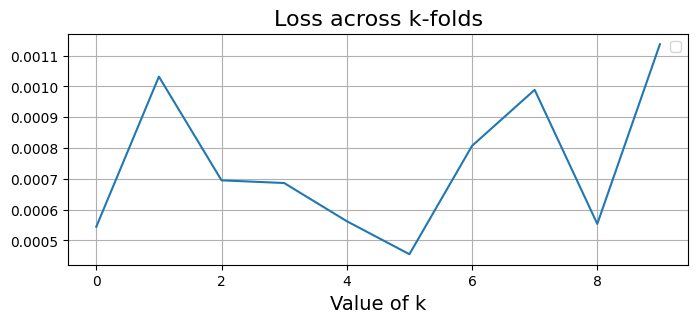

In [37]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

### Loss curves

In [38]:
# Training and Validation Loss
#plot_loss_curve(history_best_model, NUM_EPOCHS)

# Prediction on Test Dataset

In [39]:
# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)

Elapsed time: 0.0238 seconds
Maxval here is:  25.192127
Maxval here is:  0.9278


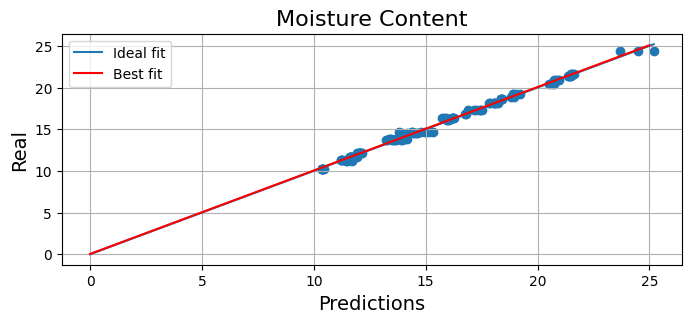

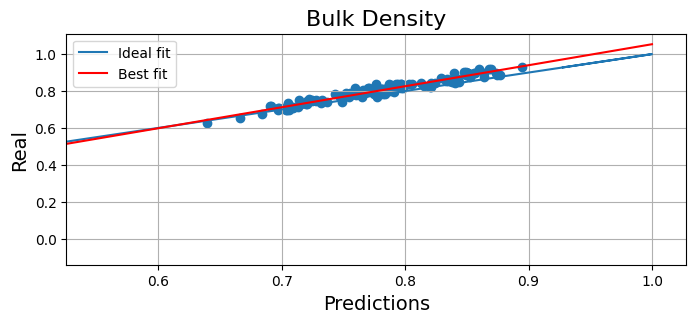

In [40]:
import time

start_time = time.time()
Y_pred_normalized = best_model.predict(X_test_norm)
end_time = time.time()
Y_pred_normalized_entire = best_model.predict(dataset_x_norm)
# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")


Y_pred = scaler_output.inverse_transform(Y_pred_normalized)
Y_pred_entire = scaler_output.inverse_transform(Y_pred_normalized_entire)
Y_actual = np.array(y_test)
Y_actual_entire = np.array(df_targets)
# Moisture Content
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_MC.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Bulk Density
scatter_plot(trueValues=Y_actual[:,1], 
             predictions=Y_pred[:,1], 
             title="Bulk Density")
plt.xlim([min(min(Y_pred[:,1]), min(Y_actual[:,1]))-0.1, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1])
a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_BD.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [41]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#   - R-squared
# mc_r2_score = r2_score(Y_actual[:, 0], Y_pred[:, 0])
mc_r2_score = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("{:#.4g}".format(mc_r2_score))

# BULK DENSITY
#   - R-squared
# bd_r2_score = r2_score(Y_actual[:, 1], Y_pred[:, 1])
bd_r2_score = calculate_r_squared(y_true=Y_actual[:, 1], y_pred=Y_pred[:, 1])
print("{:#.4g}".format(bd_r2_score))


0.9951
0.9435


### RMSE

In [42]:
from sklearn.metrics import mean_squared_error
from sigfig import round

#MC
rmse_mc = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE_MC: ', "{0:.4g}".format(rmse_mc))

#BD
rmse_bd = np.sqrt(mean_squared_error(Y_actual[:, 1], Y_pred[:, 1]))
print('RMSE_BD: ', "{0:.4g}".format(rmse_bd))

RMSE_MC:  0.2576
RMSE_BD:  0.02913


Now we will compare with the results from Trabelsi's paper. This is single moisture prediction 

R^2 : 0.993\
Mean Squared Error: 0.028\
Mean absolute Error: 0.135\
Min. Absolute Error: 0.004\
Max Absolute Error: 0.441

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))




R^2: 0.9949
Mean Squared Error:  0.06634
Mean Absolute Error:  0.1895
Min Absolute Error:  0.0016549682617181816
Max Absolute Error:  0.8069008636474617


In [44]:
mc_r2_score = r2_score(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual_entire[:,0])):
    sum = Y_actual_entire[:,0][i] - Y_pred_entire[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9966
Mean Squared Error:  0.04889
Mean Absolute Error:  0.1678
Min Absolute Error:  0.00019775390624943157
Max Absolute Error:  0.9824071502685534
